<a href="https://colab.research.google.com/github/DAN-BIWOTT/Arasaka-TradingSystems/blob/main/Ensembled_SVR_%26_SFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install skl2onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.2 which is incompatible.
tensorflow 

# Import Data Set

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re

In [3]:
from google.colab import drive, files
drive.mount('/content/drive') # mount your google colab file

Mounted at /content/drive


In [4]:
filename_in_drive = "/content/drive/My Drive/Forex/Market Data USDJPY before 2024.12.01.csv"
data = pd.read_csv(filename_in_drive)
# Version Number
model_version = "2.1"
# Extract date from filename_in_drive
match = re.search(r'\b(\d{4}\.\d{2}\.\d{2})\b', filename_in_drive)
if match:
    extracted_date = match.group(1)
else:
    print("No date found in the filename.")
data.head(3)

,Time,Open,High,Low,Close,Volume
0,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
1,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
2,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0


In [5]:
num_rows = len(data)
num_rows

99481

In [6]:
data = data[::-1]
# Reduce the dataset to the first 10,000 rows because
data = data.head(10000)
original_data = data.copy()

data.head(3)

,Time,Open,High,Low,Close,Volume
99480,2024.11.29 23:00:00,149.636,149.735,149.573,149.616,6690
99479,2024.11.29 22:00:00,149.600,149.654,149.526,149.635,11627
99478,2024.11.29 21:00:00,149.640,149.691,149.470,149.597,10329


In [7]:
num_rows = len(data)
num_rows

10000

In [8]:
data.tail()

,Time,Open,High,Low,Close,Volume
89485,2023.04.25 12:00:00,134.104,134.151,133.811,133.837,2759
89484,2023.04.25 11:00:00,134.145,134.198,134.019,134.104,3423
89483,2023.04.25 10:00:00,134.447,134.455,134.044,134.146,5205
89482,2023.04.25 09:00:00,134.190,134.476,134.068,134.446,2531
89481,2023.04.25 08:00:00,134.285,134.298,134.146,134.186,1359


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 99480 to 89481
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  object 
 1   Open    10000 non-null  float64
 2   High    10000 non-null  float64
 3   Low     10000 non-null  float64
 4   Close   10000 non-null  float64
 5   Volume  10000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 468.9+ KB


In [10]:
#Define the forecast horizon
look_ahead = 1

In [11]:
#Calculate the median, which is the midpoint between the high and low prices.
data['Candlestick_Median'] = (data['High'] + data['Low']) / 2

data.head()

,Time,Open,High,Low,Close,Volume,Candlestick_Median
99480,2024.11.29 23:00:00,149.636,149.735,149.573,149.616,6690,149.6540
99479,2024.11.29 22:00:00,149.600,149.654,149.526,149.635,11627,149.5900
99478,2024.11.29 21:00:00,149.640,149.691,149.470,149.597,10329,149.5805
99477,2024.11.29 20:00:00,149.592,149.679,149.456,149.640,7129,149.5675
99476,2024.11.29 19:00:00,150.413,150.441,149.573,149.588,6562,150.0070


In [12]:
data['Candlestick_Median'] = data['Candlestick_Median'].shift(-1)
data = data.rename(columns={'Candlestick_Median': 'Future_Median'})
data['Price_Difference'] = data['High'] - data['Low']
data['Open_Close_Change_Pct'] = (data['Close'] - data['Open']) / data['Open'] * 100
data['High_Low_Change_Pct'] = (data['High'] - data['Low']) / data['Low'] * 100
data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean() # 20-period moving average of volume
data['Volume_Change_Pct'] = data['Volume'].pct_change() * 100 # Percentage change in volume

In [13]:
data.head()

,Time,Open,High,Low,Close,Volume,Future_Median,Price_Difference,Open_Close_Change_Pct,High_Low_Change_Pct,Volume_MA_20,Volume_Change_Pct
99480,2024.11.29 23:00:00,149.636,149.735,149.573,149.616,6690,149.5900,0.162,-0.013366,0.108308,NaN,NaN
99479,2024.11.29 22:00:00,149.600,149.654,149.526,149.635,11627,149.5805,0.128,0.023396,0.085604,NaN,73.796712
99478,2024.11.29 21:00:00,149.640,149.691,149.470,149.597,10329,149.5675,0.221,-0.028736,0.147856,NaN,-11.163671
99477,2024.11.29 20:00:00,149.592,149.679,149.456,149.640,7129,150.0070,0.223,0.032087,0.149208,NaN,-30.980734
99476,2024.11.29 19:00:00,150.413,150.441,149.573,149.588,6562,150.3350,0.868,-0.548490,0.580319,NaN,-7.953430


In [14]:
# Create lagged median prices
data['median_t-1'] = data['Future_Median'].shift(2)
data['median_t-2'] = data['Future_Median'].shift(3)

In [15]:
# Update features (X)
X = data[["Open", "High", "Low", "Close", "Price_Difference", "Open_Close_Change_Pct",
          "High_Low_Change_Pct", "Volume", "Volume_MA_20", "Volume_Change_Pct",
          "median_t-1", "median_t-2"]].copy()
y = data["Future_Median"]  # Target variable

In [16]:
# Removing NAN Values while preserving time series structure
# Creating a temporary DataFrame combining X and y for consistent indexing
temp_df = pd.concat([X, y], axis=1)

# Dropping rows with NaN values in any column (features or target)
temp_df.dropna(inplace=True)

# Extractting updated X and y from the temporary DataFrame
X = temp_df[X.columns]  # Features
y = temp_df[y.name]  # Target variable

 Ensemble an SVR and an SFN

In [17]:
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np

scale

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
print("NaN values in X (features):")
print(X[X.isnull().any(axis=1)])  # Display rows with NaN in X

print("\nNaN values in y (target):")
print(y[y.isnull()])

NaN values in X (features):
Empty DataFrame
Columns: [Open, High, Low, Close, Price_Difference, Open_Close_Change_Pct, High_Low_Change_Pct, Volume, Volume_MA_20, Volume_Change_Pct, median_t-1, median_t-2]
Index: []

NaN values in y (target):
Series([], Name: Future_Median, dtype: float64)


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}  # Example hyperparameter grid
grid_search = GridSearchCV(LinearSVR(max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_linear_svr_model = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

SFN with Grid search

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Define the hyperparameter grid for the SFN (MLPRegressor)
param_grid_sfn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Create GridSearchCV object for the SFN
grid_search_sfn = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42),
                               param_grid_sfn, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search_sfn.fit(X_train, y_train)

# Get the best SFN model
best_sfn_model = grid_search_sfn.best_estimator_

print("Best SFN Model:")
print(best_sfn_model)

Temporary SFN without Grid search

In [23]:
# from sklearn.neural_network import MLPRegressor

# # Define the SFN model with pre-selected hyperparameters
# best_sfn_model = MLPRegressor(
#     hidden_layer_sizes=(100,),  # Example: Using one hidden layer with 100 neurons
#     activation='relu',        # Example: Using ReLU activation function
#     solver='adam',            # Example: Using the Adam optimizer
#     alpha=0.001,             # Example: Setting regularization strength
#     learning_rate='constant', # Example: Using a constant learning rate
#     max_iter=1000,           # Maximum number of iterations
#     random_state=42          # For reproducibility
# )

# # Fit the SFN model to the training data
# best_sfn_model.fit(X_train, y_train)

# print("SFN Model:")
# print(best_sfn_model)

SFN Model:
MLPRegressor(alpha=0.001, max_iter=1000, random_state=42)


In [24]:
ensemble_model = VotingRegressor(estimators=[('linear_svr', best_linear_svr_model), ('sfn', best_sfn_model)],
                                 weights=[0.7, 0.3])  # Example: 0.7 for LinearSVR, 0.3 for SFN
ensemble_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingRegressor(estimators=[('linear_svr',
                             LinearSVR(C=10, epsilon=0.01, max_iter=10000)),
                            ('sfn',
                             MLPRegressor(alpha=0.001, max_iter=1000,
                                          random_state=42))],
                weights=[0.7, 0.3])

In [25]:
# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of Ensemble: {mse}")

Mean Squared Error of Ensemble: 0.010680739330571086


Graph the perfomance

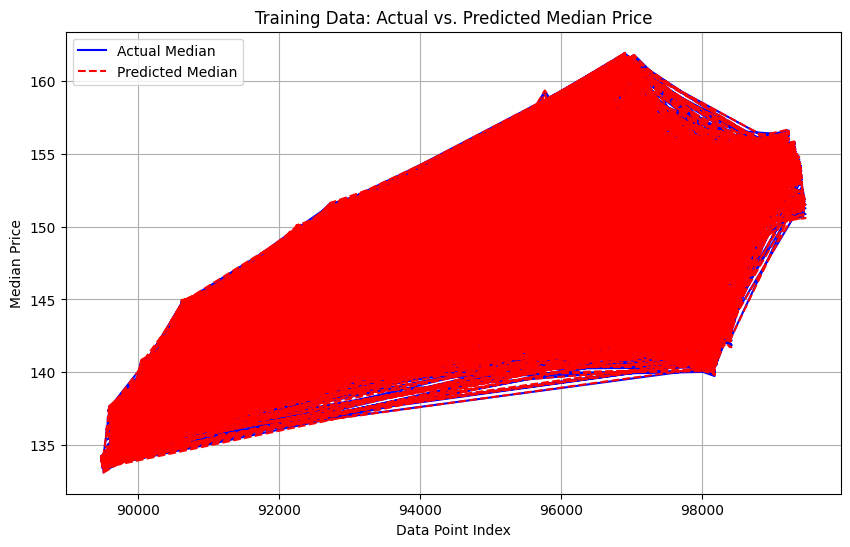

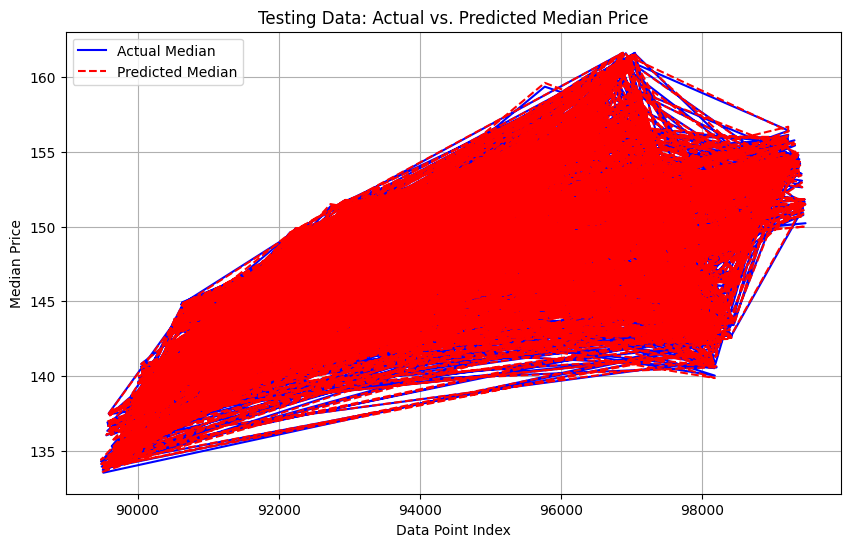

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Predictions (Same as before)
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# 2. Training Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_train.index, y_train_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Training Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. Testing Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_test.index, y_test_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Testing Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# 1. Calculate Performance Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_explained_variance = explained_variance_score(y_train, y_train_pred)
test_explained_variance = explained_variance_score(y_test, y_test_pred)

# 2. Store Metrics in a Dictionary
performance_metrics = {
    "train_mse": train_mse,
    "test_mse": test_mse,
    "train_rmse": train_rmse,
    "test_rmse": test_rmse,
    "train_mae": train_mae,
    "test_mae": test_mae,
    "train_r2": train_r2,
    "test_r2": test_r2,
    "train_explained_variance": train_explained_variance,
    "test_explained_variance": test_explained_variance
}

# 3. Get Features and Model Name
features = list(X.columns)
model_name = f"{model_version}_Ensemble Model (Linear SVR + SFN)_{extracted_date}"  # Update model name

# 4. (Optional) Scaling Parameters - If you used scaling, include this part
scaling_parameters = {
    "mean": scaler.mean_.tolist(),
    "std_dev": scaler.scale_.tolist()
}

# 5. Create Log Data Dictionary
log_data = {
    "model_name": model_name,
    "features": features,
    "performance_metrics": performance_metrics,
    # "scaling_parameters": scaling_parameters  # Include if you have scaling parameters
}

# 6. Save to JSON File
# Assuming 'extracted_date' is defined earlier in your code
with open(f"{model_name}_log_{extracted_date}.json", "w") as f:
    json.dump(log_data, f, indent=4)

print(f"{model_version}_Model log saved to {model_name}_log_{extracted_date}.json")

2.1_Model log saved to 2.1_Ensemble Model (Linear SVR + SFN)_2024.12.01_log_2024.12.01.json


In [28]:
print("Scaling Mean:", ', '.join(map(str, scaler.mean_)))
print("Scaling Standard Deviation:", ', '.join(map(str, scaler.scale_)))

Scaling Mean: 148.26287111723448, 148.373624498998, 148.1429582915832, 148.26610308116233, 0.23066620741482952, 0.0023105355813956645, 0.15661644818235604, 4487.236598196393, 4475.038389278557, 18.735038224022066, 148.26052379759517, 148.2629431988978
Scaling Standard Deviation: 6.090629281929516, 6.078472992361546, 6.098301961901028, 6.088898696784167, 0.20604930553867687, 0.12280714114072477, 0.1403479567460024, 3033.711711336998, 1880.2397850336224, 117.9703133170539, 6.085256877910959, 6.082029561790399


ONNX file Generation

In [29]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

In [30]:
initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features

In [31]:
# Convert weights to a NumPy array before converting to ONNX
ensemble_model.weights = np.array(ensemble_model.weights)

initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features
onnx_model = convert_sklearn(ensemble_model, initial_types=initial_type)
with open(f"{model_version}_ensemble_model_{extracted_date}.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())